## Imports

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, adjusted_rand_score, silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
import time
import warnings

from DataManagment import *
from Classifiers import *
from Evaluators import *
from Metrics import *
from ResultsManagment import *


## Code

In [6]:
dataLoader = DataLoader("../data")
dataset = dataLoader.load_dataset('iris')
if dataset is None:
    print("Failed to load dataset.")
else:
    evaluator = Evaluator()
    knn = KNNWrapper(metric_func=EuclideanMetric(), n_neighbors=10)
    svm = SVMWrapper(metric_func=EuclideanMetric())

    score = evaluator.crossValidateClassifier(dataset, svm, n_splits=5)
    print(f"Accuracy: {score:.2f}")


Loading Iris dataset from: ../data/iris.csv
Iris dataset not found locally. Please download it from UCI repository or run setup.sh script!
URL: https://archive.ics.uci.edu/ml/datasets/seeds
Failed to load dataset.


In [7]:
warnings.filterwarnings('ignore')

class CustomMetricEvaluator:
    """
    A class to evaluate classifiers with custom distance metrics on various datasets.
    """
    
    def __init__(self):
        self.dataset_loaders = {
            'iris': self.load_iris,
            'wine': self.load_wine,
            'seeds': self.load_seeds,
            'banknote': self.load_banknote,
            'heart': self.load_heart,
            'adult': self.load_adult
        }
        
        # Standard distance metrics to test
        self.metrics = {
            'euclidean': 'euclidean',
            'manhattan': 'manhattan',
            'cosine': 'cosine',
            'chebyshev': 'chebyshev'
        }
        
    def load_dataset(self, dataset_name):
        """Load and preprocess a specific dataset."""
        if dataset_name in self.dataset_loaders:
            return self.dataset_loaders[dataset_name]()
        else:
            raise ValueError(f"Dataset '{dataset_name}' not recognized. Available datasets: {list(self.dataset_loaders.keys())}")
    
    def load_iris(self):
        """Load Iris dataset."""
        from sklearn.datasets import load_iris
        data = load_iris()
        X, y = data.data, data.target
        feature_names = data.feature_names
        target_names = data.target_names
        
        return X, y, feature_names, target_names, None, None
    
    def load_wine(self):
        """Load Wine dataset."""
        from sklearn.datasets import load_wine
        data = load_wine()
        X, y = data.data, data.target
        feature_names = data.feature_names
        target_names = data.target_names
        
        return X, y, feature_names, target_names, None, None
    
    def load_seeds(self):
        """Load Seeds dataset."""
        # Try to load from local file first
        try:
            df = pd.read_csv('seeds_dataset.txt', sep='\t', header=None)
            X = df.iloc[:, :-1].values
            y = df.iloc[:, -1].values - 1  # Classes are 1-3, convert to 0-2
            feature_names = [f'Feature_{i}' for i in range(X.shape[1])]
            target_names = [f'Class_{i}' for i in range(len(np.unique(y)))]
            return X, y, feature_names, target_names, None, None
        except:
            print("Seeds dataset not found locally. Please download it from UCI repository.")
            print("URL: https://archive.ics.uci.edu/ml/datasets/seeds")
            return None, None, None, None, None, None
    
    def load_banknote(self):
        """Load Banknote Authentication dataset."""
        try:
            df = pd.read_csv('data_banknote_authentication.txt', header=None)
            X = df.iloc[:, :-1].values
            y = df.iloc[:, -1].values
            feature_names = ['Variance', 'Skewness', 'Curtosis', 'Entropy']
            target_names = ['Authentic', 'Counterfeit']
            return X, y, feature_names, target_names, None, None
        except:
            print("Banknote dataset not found locally. Please download it from UCI repository.")
            print("URL: https://archive.ics.uci.edu/ml/datasets/banknote+authentication")
            return None, None, None, None, None, None
    
    def load_heart(self):
        """Load Heart Disease dataset."""
        try:
            df = pd.read_csv('heart.csv')
            X = df.drop('target', axis=1).values
            y = df['target'].values
            feature_names = list(df.drop('target', axis=1).columns)
            target_names = ['No Disease', 'Disease']
            return X, y, feature_names, target_names, None, None
        except:
            print("Heart disease dataset not found locally. Please download it.")
            print("URL: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction")
            return None, None, None, None, None, None
    
    def load_adult(self):
        """Load Adult Census Income dataset with preprocessing."""
        try:
            # Column names for the Adult dataset
            column_names = [
                'age', 'workclass', 'fnlwgt', 'education', 'education-num',
                'marital-status', 'occupation', 'relationship', 'race', 'sex',
                'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
            ]
            
            # Load the data
            df = pd.read_csv('adult.data', header=None, names=column_names, na_values=' ?')
            
            # Identify categorical and numerical columns
            categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
            numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
            
            # Remove the target column from feature columns
            if 'income' in categorical_cols:
                categorical_cols.remove('income')
            if 'income' in numerical_cols:
                numerical_cols.remove('income')
            
            # Define preprocessing for numerical and categorical data
            numerical_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ])
            
            categorical_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ])
            
            # Bundle preprocessing for numerical and categorical data
            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numerical_transformer, numerical_cols),
                    ('cat', categorical_transformer, categorical_cols)
                ])
            
            # Extract features and target
            X = df.drop('income', axis=1)
            y = (df['income'] == ' >50K').astype(int)  # 1 if income >50K, 0 otherwise
            
            feature_names = list(X.columns)
            target_names = ['<=50K', '>50K']
            
            return X, y, feature_names, target_names, preprocessor, categorical_cols
        except:
            print("Adult dataset not found locally. Please download it from UCI repository.")
            print("URL: https://archive.ics.uci.edu/ml/datasets/adult")
            return None, None, None, None, None, None
            
    def add_custom_metric(self, name, metric_function):
        """
        Add a custom distance metric to the evaluator.
        
        Parameters:
        -----------
        name : str
            Name of the custom metric
        metric_function : callable
            Function that takes two points and returns their distance
        """
        self.metrics[name] = metric_function
    
    def evaluate_knn(self, X_train, X_test, y_train, y_test, metric='euclidean', n_neighbors=5):
        """Evaluate KNN classifier with specified metric."""
        start_time = time.time()
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        elapsed = time.time() - start_time
        
        return {
            'accuracy': accuracy,
            'time': elapsed,
            'model': knn
        }
    
    def evaluate_kmeans(self, X_train, X_test, y_train, y_test, metric='euclidean', n_clusters=None):
        """Evaluate KMeans clustering with specified metric."""
        if n_clusters is None:
            n_clusters = len(np.unique(y_train))
        
        start_time = time.time()
        
        # For K-means, we need to adapt based on the metric
        # Standard K-means uses euclidean, for other metrics we need to use specialized algorithms
        # or precomputed distance matrices which is complex for large datasets
        
        if metric == 'euclidean':
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            kmeans.fit(X_train)
            train_labels = kmeans.labels_
            test_labels = kmeans.predict(X_test)
        else:
            # For non-euclidean metrics, this is a simplified approach
            # In a real scenario you might want to use spectral clustering or other methods
            from sklearn.cluster import AgglomerativeClustering
            kmeans = AgglomerativeClustering(n_clusters=n_clusters, affinity=metric 
                                           if isinstance(metric, str) else 'precomputed',
                                           linkage='average')
            
            # If using custom metric function, compute distance matrix
            if not isinstance(metric, str):
                from sklearn.metrics import pairwise_distances
                dist_matrix = pairwise_distances(X_train, metric=metric)
                kmeans = AgglomerativeClustering(n_clusters=n_clusters, 
                                               affinity='precomputed',
                                               linkage='average')
                kmeans.fit(dist_matrix)
            else:
                kmeans.fit(X_train)
            
            train_labels = kmeans.labels_
            
            # For prediction on test set with Agglomerative Clustering
            # we need a custom approach - assign test points to nearest cluster
            from scipy.spatial.distance import cdist
            
            # Get cluster centers from training data
            centers = np.zeros((n_clusters, X_train.shape[1]))
            for i in range(n_clusters):
                cluster_points = X_train[train_labels == i]
                if len(cluster_points) > 0:
                    centers[i] = np.mean(cluster_points, axis=0)
            
            # Assign test points to nearest cluster
            if isinstance(metric, str):
                distances = cdist(X_test, centers, metric=metric)
            else:
                distances = np.zeros((X_test.shape[0], n_clusters))
                for i in range(X_test.shape[0]):
                    for j in range(n_clusters):
                        distances[i, j] = np.mean([metric(X_test[i], X_train[k]) 
                                                 for k in range(X_train.shape[0]) 
                                                 if train_labels[k] == j])
            
            test_labels = np.argmin(distances, axis=1)
        
        # Evaluate clustering
        train_ari = adjusted_rand_score(y_train, train_labels)
        test_ari = adjusted_rand_score(y_test, test_labels)
        
        # Calculate silhouette score if possible (requires more than 1 sample per cluster)
        try:
            silhouette = silhouette_score(X_train, train_labels, metric=metric 
                                        if isinstance(metric, str) else partial(self._pairwise_metric, metric=metric))
        except:
            silhouette = None
        
        elapsed = time.time() - start_time
        
        return {
            'train_ari': train_ari,
            'test_ari': test_ari,
            'silhouette': silhouette,
            'time': elapsed,
            'model': kmeans if isinstance(kmeans, KMeans) else None
        }
    
    def _pairwise_metric(self, X, Y=None, metric=None):
        """Helper function to compute pairwise distances with custom metric."""
        from sklearn.metrics import pairwise_distances
        return pairwise_distances(X, Y, metric=metric)
    
    def evaluate_svm(self, X_train, X_test, y_train, y_test, metric='rbf', C=1.0):
        """Evaluate SVM classifier with specified kernel."""
        start_time = time.time()
        
        # For SVM, we need to handle custom kernels differently
        if metric in ['linear', 'poly', 'rbf', 'sigmoid']:
            svm = SVC(kernel=metric, C=C, gamma='scale')
            svm.fit(X_train, y_train)
        else:
            # For custom metrics, we convert to a kernel matrix
            # Note: Not all distance metrics can be validly converted to kernels
            # This is a simple approximation for demonstration
            from sklearn.metrics.pairwise import pairwise_distances
            
            # Convert distance to similarity (kernel)
            def distance_to_kernel(X, Y=None, metric=metric):
                if Y is None:
                    Y = X
                if isinstance(metric, str):
                    D = pairwise_distances(X, Y, metric=metric)
                else:
                    D = np.zeros((X.shape[0], Y.shape[0]))
                    for i in range(X.shape[0]):
                        for j in range(Y.shape[0]):
                            D[i, j] = metric(X[i], Y[j])
                # Convert distance to similarity using Gaussian kernel
                sigma = np.median(D)
                K = np.exp(-0.5 * D / (sigma ** 2))
                return K
            
            # Create precomputed kernel matrices
            K_train = distance_to_kernel(X_train)
            K_test = distance_to_kernel(X_test, X_train)
            
            # Train SVM with precomputed kernel
            svm = SVC(kernel='precomputed', C=C)
            svm.fit(K_train, y_train)
            y_pred = svm.predict(K_test)
        
        if metric in ['linear', 'poly', 'rbf', 'sigmoid']:
            y_pred = svm.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        elapsed = time.time() - start_time
        
        return {
            'accuracy': accuracy,
            'time': elapsed,
            'model': svm
        }
    
    def run_evaluations(self, dataset_name, test_size=0.3, random_state=42):
        """Run all evaluations for a given dataset."""
        # Load dataset
        data = self.load_dataset(dataset_name)
        if data[0] is None:
            return None
        
        X, y, feature_names, target_names, preprocessor, categorical_cols = data
        
        # Handle preprocessing for complex datasets like Adult
        if preprocessor is not None:
            if isinstance(X, pd.DataFrame):
                # For datasets with categorical features that need preprocessing
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=test_size, random_state=random_state, stratify=y
                )
                X_train_processed = preprocessor.fit_transform(X_train)
                X_test_processed = preprocessor.transform(X_test)
            else:
                # Should not happen but just in case
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=test_size, random_state=random_state, stratify=y
                )
                X_train_processed = X_train
                X_test_processed = X_test
        else:
            # For simple numerical datasets
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_size, random_state=random_state, stratify=y
            )
            
            # Apply standard scaling
            scaler = StandardScaler()
            X_train_processed = scaler.fit_transform(X_train)
            X_test_processed = scaler.transform(X_test)
        
        # Results dictionary
        results = {
            'dataset': dataset_name,
            'n_samples': len(y),
            'n_features': X_train_processed.shape[1],
            'n_classes': len(np.unique(y)),
            'feature_names': feature_names,
            'target_names': target_names,
            'knn': {},
            'kmeans': {},
            'svm': {}
        }
        
        # Evaluate KNN with different metrics
        print(f"Evaluating KNN on {dataset_name}...")
        for metric_name, metric in self.metrics.items():
            try:
                results['knn'][metric_name] = self.evaluate_knn(
                    X_train_processed, X_test_processed, y_train, y_test, metric=metric
                )
                print(f"  {metric_name}: {results['knn'][metric_name]['accuracy']:.4f}")
            except Exception as e:
                print(f"  Error with KNN using {metric_name}: {str(e)}")
                results['knn'][metric_name] = {'error': str(e)}
        
        # Evaluate KMeans with different metrics
        print(f"Evaluating KMeans on {dataset_name}...")
        for metric_name, metric in self.metrics.items():
            if metric_name in ['euclidean', 'manhattan', 'cosine']:  # Only standard metrics for KMeans
                try:
                    results['kmeans'][metric_name] = self.evaluate_kmeans(
                        X_train_processed, X_test_processed, y_train, y_test, metric=metric
                    )
                    print(f"  {metric_name}: ARI={results['kmeans'][metric_name]['test_ari']:.4f}, "
                          f"Silhouette={results['kmeans'][metric_name]['silhouette']:.4f if results['kmeans'][metric_name]['silhouette'] is not None else 'N/A'}")
                except Exception as e:
                    print(f"  Error with KMeans using {metric_name}: {str(e)}")
                    results['kmeans'][metric_name] = {'error': str(e)}
        
        # Evaluate SVM with different kernels
        print(f"Evaluating SVM on {dataset_name}...")
        for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
            try:
                results['svm'][kernel] = self.evaluate_svm(
                    X_train_processed, X_test_processed, y_train, y_test, metric=kernel
                )
                print(f"  {kernel}: {results['svm'][kernel]['accuracy']:.4f}")
            except Exception as e:
                print(f"  Error with SVM using {kernel}: {str(e)}")
                results['svm'][kernel] = {'error': str(e)}
        
        # Try to convert distance metrics to SVM kernels
        for metric_name, metric in self.metrics.items():
            if metric_name not in ['euclidean', 'manhattan', 'cosine', 'chebyshev']:
                continue  # Skip custom metrics for now
                
            kernel_name = f"{metric_name}_kernel"
            try:
                results['svm'][kernel_name] = self.evaluate_svm(
                    X_train_processed, X_test_processed, y_train, y_test, metric=metric
                )
                print(f"  {kernel_name}: {results['svm'][kernel_name]['accuracy']:.4f}")
            except Exception as e:
                print(f"  Error with SVM using {kernel_name}: {str(e)}")
                results['svm'][kernel_name] = {'error': str(e)}
        
        return results
    
    def visualize_results(self, results):
        """Visualize evaluation results."""
        if results is None:
            return
        
        # Create figure for accuracy comparisons
        plt.figure(figsize=(14, 8))
        
        # KNN comparison
        plt.subplot(1, 2, 1)
        knn_metrics = []
        knn_accuracies = []
        
        for metric_name, result in results['knn'].items():
            if 'accuracy' in result:
                knn_metrics.append(metric_name)
                knn_accuracies.append(result['accuracy'])
        
        sns.barplot(x=knn_metrics, y=knn_accuracies)
        plt.title(f"KNN Accuracy on {results['dataset']} Dataset")
        plt.xlabel("Distance Metric")
        plt.ylabel("Accuracy")
        plt.xticks(rotation=45)
        plt.ylim(0, 1)
        
        # SVM comparison
        plt.subplot(1, 2, 2)
        svm_kernels = []
        svm_accuracies = []
        
        for kernel_name, result in results['svm'].items():
            if 'accuracy' in result:
                svm_kernels.append(kernel_name)
                svm_accuracies.append(result['accuracy'])
        
        sns.barplot(x=svm_kernels, y=svm_accuracies)
        plt.title(f"SVM Accuracy on {results['dataset']} Dataset")
        plt.xlabel("Kernel")
        plt.ylabel("Accuracy")
        plt.xticks(rotation=45)
        plt.ylim(0, 1)
        
        plt.tight_layout()
        plt.show()
        
        # KMeans visualization
        plt.figure(figsize=(14, 6))
        
        # ARI comparison
        plt.subplot(1, 2, 1)
        kmeans_metrics = []
        kmeans_aris = []
        
        for metric_name, result in results['kmeans'].items():
            if 'test_ari' in result:
                kmeans_metrics.append(metric_name)
                kmeans_aris.append(result['test_ari'])
        
        sns.barplot(x=kmeans_metrics, y=kmeans_aris)
        plt.title(f"KMeans ARI on {results['dataset']} Dataset")
        plt.xlabel("Distance Metric")
        plt.ylabel("Adjusted Rand Index")
        plt.xticks(rotation=45)
        plt.ylim(0, 1)
        
        # Silhouette comparison
        plt.subplot(1, 2, 2)
        kmeans_metrics = []
        kmeans_silhouettes = []
        
        for metric_name, result in results['kmeans'].items():
            if 'silhouette' in result and result['silhouette'] is not None:
                kmeans_metrics.append(metric_name)
                kmeans_silhouettes.append(result['silhouette'])
        
        if kmeans_metrics:
            sns.barplot(x=kmeans_metrics, y=kmeans_silhouettes)
            plt.title(f"KMeans Silhouette on {results['dataset']} Dataset")
            plt.xlabel("Distance Metric")
            plt.ylabel("Silhouette Score")
            plt.xticks(rotation=45)
            plt.ylim(-1, 1)
        else:
            plt.text(0.5, 0.5, "No valid silhouette scores available", 
                    horizontalalignment='center', verticalalignment='center')
        
        plt.tight_layout()
        plt.show()
        
    def define_custom_distance_metric(self, name, metric_function):
        """Define a custom distance metric for evaluation."""
        self.metrics[name] = metric_function
        print(f"Added custom metric: {name}")

# Example usage
def example_custom_metric(x, y):
    """
    Example of a custom distance metric - weighted Euclidean distance
    that emphasizes the first half of features more than the second half.
    """
    n_features = len(x)
    weights = np.ones(n_features)
    weights[:n_features//2] = 2.0  # Double weight for first half of features
    
    return np.sqrt(np.sum(weights * ((x - y) ** 2)))

# Example notebook cell
def run_example():
    # Create evaluator
    evaluator = CustomMetricEvaluator()
    
    # Add custom metric if desired
    evaluator.define_custom_distance_metric('weighted_euclidean', example_custom_metric)
    
    # Run evaluations on Iris dataset
    results = evaluator.run_evaluations('iris')
    
    # Visualize results
    evaluator.visualize_results(results)
    
    # Run on another dataset
    results_wine = evaluator.run_evaluations('wine')
    evaluator.visualize_results(results_wine)

# Example of defining an evolutionary metric 
def create_evolutionary_metric(weights_matrix):
    """
    Create a Mahalanobis-like distance metric using an evolved weights matrix.
    
    Parameters:
    -----------
    weights_matrix : ndarray
        Square matrix of feature weights, should be positive semi-definite
        for a proper metric
    
    Returns:
    --------
    metric_function : callable
        Distance metric function that can be used with scikit-learn
    """
    def evolved_metric(x, y):
        diff = x - y
        return np.sqrt(diff.dot(weights_matrix).dot(diff))
    
    return evolved_metric

# More example usage for evolutionary metrics
def evolution_example():
    # Create evaluator
    evaluator = CustomMetricEvaluator()
    
    # Load iris dataset for demonstration
    X, y, _, _, _, _ = evaluator.load_dataset('iris')
    
    # Create a simple diagonal weight matrix (feature scaling)
    # In a real evolutionary algorithm, this would be evolved
    n_features = X.shape[1]
    weights_matrix = np.eye(n_features)  # Start with identity matrix
    
    # Modify weights to emphasize certain features
    # This is where your evolutionary algorithm would come in
    weights_matrix[0, 0] = 2.0  # Emphasize first feature
    weights_matrix[1, 1] = 0.5  # De-emphasize second feature
    
    # Create metric from weights
    evolved_metric = create_evolutionary_metric(weights_matrix)
    
    # Add to evaluator
    evaluator.define_custom_distance_metric('evolved_metric', evolved_metric)
    
    # Run evaluations
    results = evaluator.run_evaluations('iris')
    
    # Visualize results
    evaluator.visualize_results(results)

# run_example()  # Uncomment to run the basic example
# evolution_example()  # Uncomment to run the evolutionary example

In [8]:
# 1. Basic Usage Example
def basic_evaluation():
    # Create an evaluator instance
    evaluator = CustomMetricEvaluator()
    
    # Choose a dataset to evaluate
    dataset_name = 'iris'  # Options: 'iris', 'wine', 'seeds', 'banknote', 'heart', 'adult'
    
    # Run evaluations with default metrics
    results = evaluator.run_evaluations(dataset_name)
    
    # Visualize the results
    evaluator.visualize_results(results)
    
    return results

# 2. Custom Distance Metric Example
def custom_metric_example():
    # Create an evaluator instance
    evaluator = CustomMetricEvaluator()
    
    # Define a custom distance metric - weighted Euclidean
    def weighted_euclidean(x, y):
        weights = np.array([2.0, 1.0, 0.5, 1.5])  # Custom weights for features
        return np.sqrt(np.sum(weights * ((x - y) ** 2)))
    
    # Add the custom metric to the evaluator
    evaluator.define_custom_distance_metric('weighted_euclidean', weighted_euclidean)
    
    # Run evaluations with the custom metric included
    results = evaluator.run_evaluations('iris')
    
    # Visualize the results
    evaluator.visualize_results(results)
    
    return results

# 3. Mahalanobis-like Metric Example (for evolutionary algorithms)
def mahalanobis_example():
    # Create an evaluator instance
    evaluator = CustomMetricEvaluator()
    
    # Load a dataset to get the number of features
    X, y, _, _, _, _ = evaluator.load_dataset('iris')
    n_features = X.shape[1]
    
    # Create a custom weight matrix (this would be evolved in your EA)
    # Starting with a simple positive definite matrix
    W = np.eye(n_features)  # Identity matrix
    
    # Modify to create feature interactions (off-diagonal elements)
    # This represents how features interact in the distance calculation
    W[0, 1] = W[1, 0] = 0.5  # Correlation between features 0 and 1
    W[2, 3] = W[3, 2] = -0.3  # Anti-correlation between features 2 and 3
    
    # Create the metric using our weight matrix
    def mahalanobis_metric(x, y):
        diff = x - y
        return np.sqrt(diff.dot(W).dot(diff))
    
    # Add the custom metric to the evaluator
    evaluator.define_custom_distance_metric('mahalanobis_custom', mahalanobis_metric)
    
    # Run evaluations
    results = evaluator.run_evaluations('iris')
    
    # Visualize the results
    evaluator.visualize_results(results)
    
    return results, W

# 4. Comparing Multiple Datasets
def compare_datasets():
    evaluator = CustomMetricEvaluator()
    
    # List of datasets to compare
    datasets = ['iris', 'wine', 'banknote']
    
    # Store results for each dataset
    all_results = {}
    
    # Run evaluations for each dataset
    for dataset in datasets:
        print(f"\n{'='*50}")
        print(f"Evaluating {dataset} dataset")
        print(f"{'='*50}")
        results = evaluator.run_evaluations(dataset)
        all_results[dataset] = results
        
    # Create comparison visualization
    compare_knn_across_datasets(all_results)

### Experiment 1

2025-05-20 12:27:44,837 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-05-20 12:27:44,839 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-05-20 12:27:44,842 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-05-20 12:27:44,843 - DEBUG - findfont: score(FontEntry(fname='/home/guter/Masters_1/program_synthesis/inDISTrial_rEVOLUTION/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 1.05
2025-05-20 12:27:44,843 - DEBUG - findfont: score(FontEntry(fname='/home/guter/Masters_1/program_synthesis/inDISTrial_rEVOLUTION/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 

Evaluating KNN on iris...
  euclidean: 0.9111
  manhattan: 0.9111
  cosine: 0.7778
  chebyshev: 0.8889
Evaluating KMeans on iris...
  Error with KMeans using euclidean: Invalid format specifier '.4f if results['kmeans'][metric_name]['silhouette'] is not None else 'N/A'' for object of type 'float'
  Error with KMeans using manhattan: AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'
  Error with KMeans using cosine: AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'
Evaluating SVM on iris...
  linear: 0.9111
  poly: 0.8667
  rbf: 0.9333
  sigmoid: 0.9111
  euclidean_kernel: 0.9111
  manhattan_kernel: 0.9111
  cosine_kernel: 0.7778
  chebyshev_kernel: 0.8444


2025-05-20 12:27:44,902 - DEBUG - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSerifGeorgian-Regular.ttf', name='Noto Serif Georgian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-05-20 12:27:44,902 - DEBUG - findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/NimbusRoman-BoldItalic.otf', name='Nimbus Roman', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2025-05-20 12:27:44,903 - DEBUG - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansTamilSupplement-Regular.ttf', name='Noto Sans Tamil Supplement', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-05-20 12:27:44,903 - DEBUG - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSerifTibetan-Bold.ttf', name='Noto Serif Tibetan', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
20

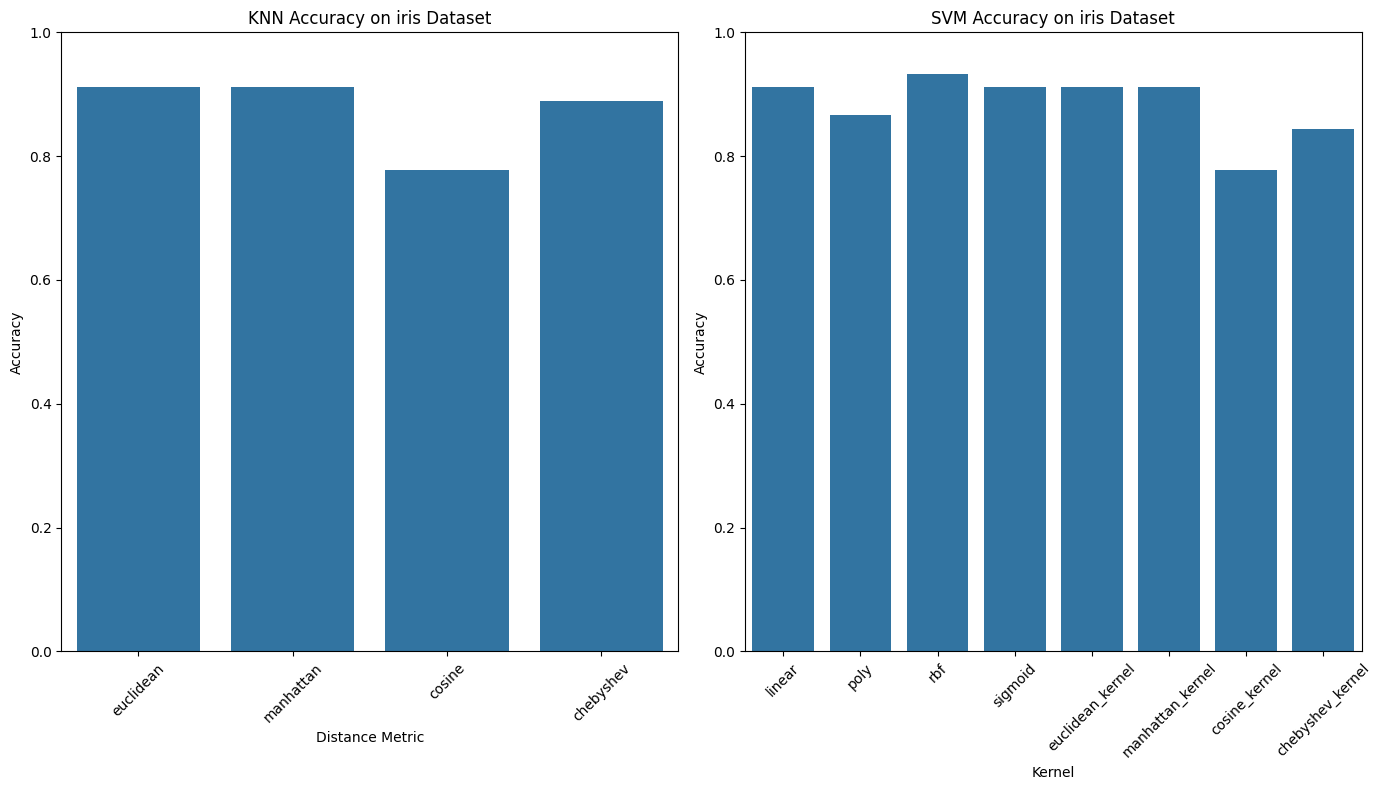

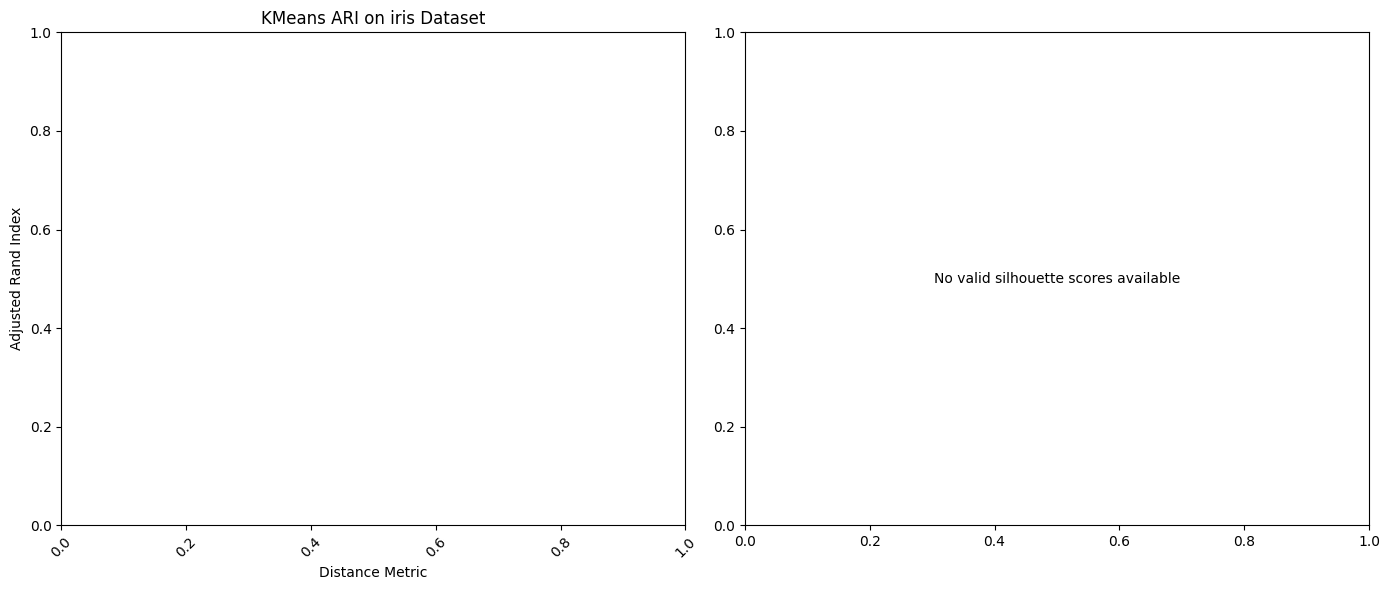

{'dataset': 'iris',
 'n_samples': 150,
 'n_features': 4,
 'n_classes': 3,
 'feature_names': ['sepal length (cm)',
  'sepal width (cm)',
  'petal length (cm)',
  'petal width (cm)'],
 'target_names': array(['setosa', 'versicolor', 'virginica'], dtype='<U10'),
 'knn': {'euclidean': {'accuracy': 0.9111111111111111,
   'time': 0.005377054214477539,
   'model': KNeighborsClassifier(metric='euclidean')},
  'manhattan': {'accuracy': 0.9111111111111111,
   'time': 0.0026862621307373047,
   'model': KNeighborsClassifier(metric='manhattan')},
  'cosine': {'accuracy': 0.7777777777777778,
   'time': 0.0030431747436523438,
   'model': KNeighborsClassifier(metric='cosine')},
  'chebyshev': {'accuracy': 0.8888888888888888,
   'time': 0.0023097991943359375,
   'model': KNeighborsClassifier(metric='chebyshev')}},
 'kmeans': {'euclidean': {'error': "Invalid format specifier '.4f if results['kmeans'][metric_name]['silhouette'] is not None else 'N/A'' for object of type 'float'"},
  'manhattan': {'error':

In [9]:
basic_evaluation()  # Uncomment to run the basic evaluation

### Experiment 2

Added custom metric: weighted_euclidean
Evaluating KNN on iris...
  euclidean: 0.9111
  manhattan: 0.9111
  cosine: 0.7778
  chebyshev: 0.8889
  weighted_euclidean: 0.9333
Evaluating KMeans on iris...
  Error with KMeans using euclidean: Invalid format specifier '.4f if results['kmeans'][metric_name]['silhouette'] is not None else 'N/A'' for object of type 'float'
  Error with KMeans using manhattan: AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'
  Error with KMeans using cosine: AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'
Evaluating SVM on iris...
  linear: 0.9111
  poly: 0.8667
  rbf: 0.9333
  sigmoid: 0.9111
  euclidean_kernel: 0.9111
  manhattan_kernel: 0.9111
  cosine_kernel: 0.7778
  chebyshev_kernel: 0.8444


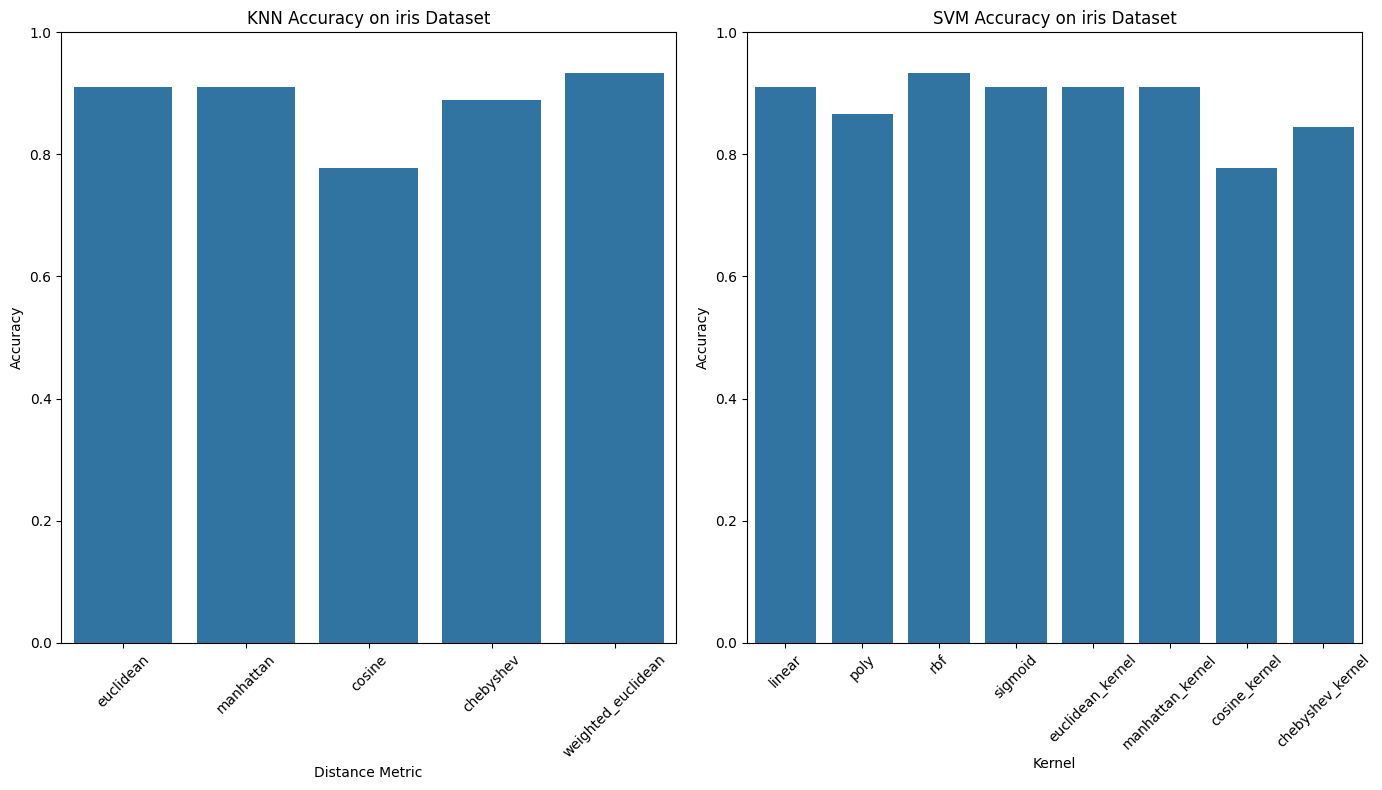

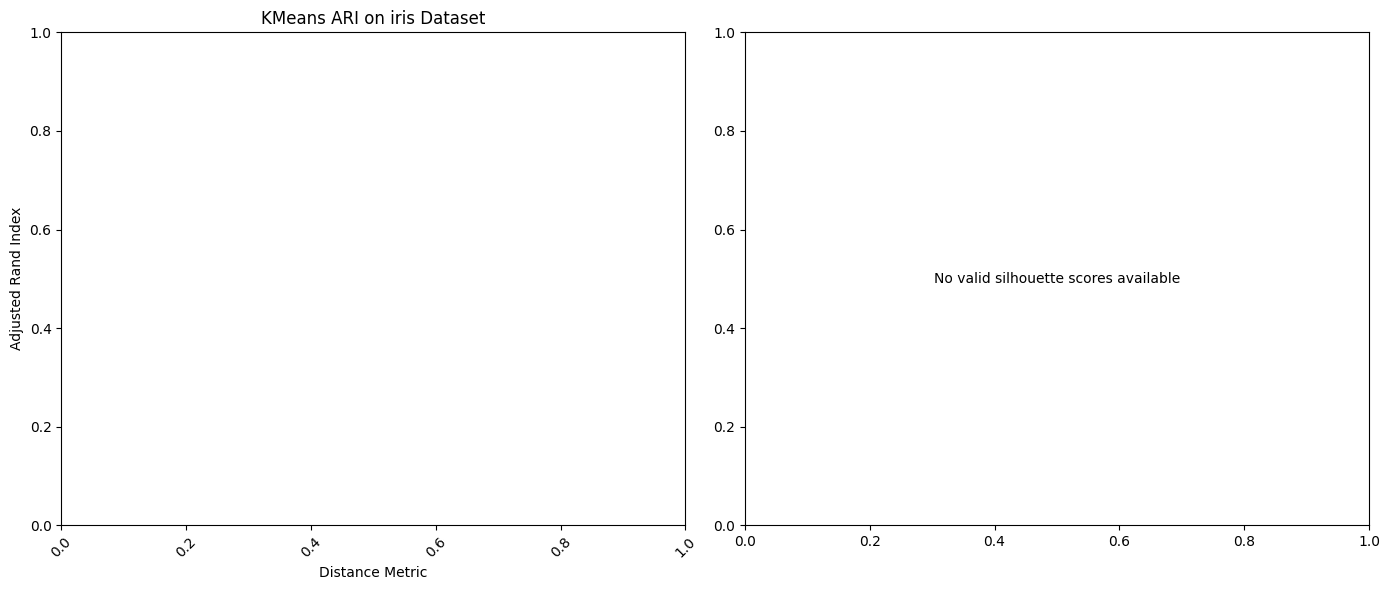

{'dataset': 'iris',
 'n_samples': 150,
 'n_features': 4,
 'n_classes': 3,
 'feature_names': ['sepal length (cm)',
  'sepal width (cm)',
  'petal length (cm)',
  'petal width (cm)'],
 'target_names': array(['setosa', 'versicolor', 'virginica'], dtype='<U10'),
 'knn': {'euclidean': {'accuracy': 0.9111111111111111,
   'time': 0.00383758544921875,
   'model': KNeighborsClassifier(metric='euclidean')},
  'manhattan': {'accuracy': 0.9111111111111111,
   'time': 0.002493143081665039,
   'model': KNeighborsClassifier(metric='manhattan')},
  'cosine': {'accuracy': 0.7777777777777778,
   'time': 0.002947092056274414,
   'model': KNeighborsClassifier(metric='cosine')},
  'chebyshev': {'accuracy': 0.8888888888888888,
   'time': 0.0022802352905273438,
   'model': KNeighborsClassifier(metric='chebyshev')},
  'weighted_euclidean': {'accuracy': 0.9333333333333333,
   'time': 0.026106595993041992,
   'model': KNeighborsClassifier(metric=<function custom_metric_example.<locals>.weighted_euclidean at 0x7

In [10]:
custom_metric_example()

### Experiment 3

Added custom metric: mahalanobis_custom
Evaluating KNN on iris...
  euclidean: 0.9111
  manhattan: 0.9111
  cosine: 0.7778
  chebyshev: 0.8889
  mahalanobis_custom: 0.9111
Evaluating KMeans on iris...
  Error with KMeans using euclidean: Invalid format specifier '.4f if results['kmeans'][metric_name]['silhouette'] is not None else 'N/A'' for object of type 'float'
  Error with KMeans using manhattan: AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'
  Error with KMeans using cosine: AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'
Evaluating SVM on iris...
  linear: 0.9111
  poly: 0.8667
  rbf: 0.9333
  sigmoid: 0.9111
  euclidean_kernel: 0.9111
  manhattan_kernel: 0.9111
  cosine_kernel: 0.7778
  chebyshev_kernel: 0.8444


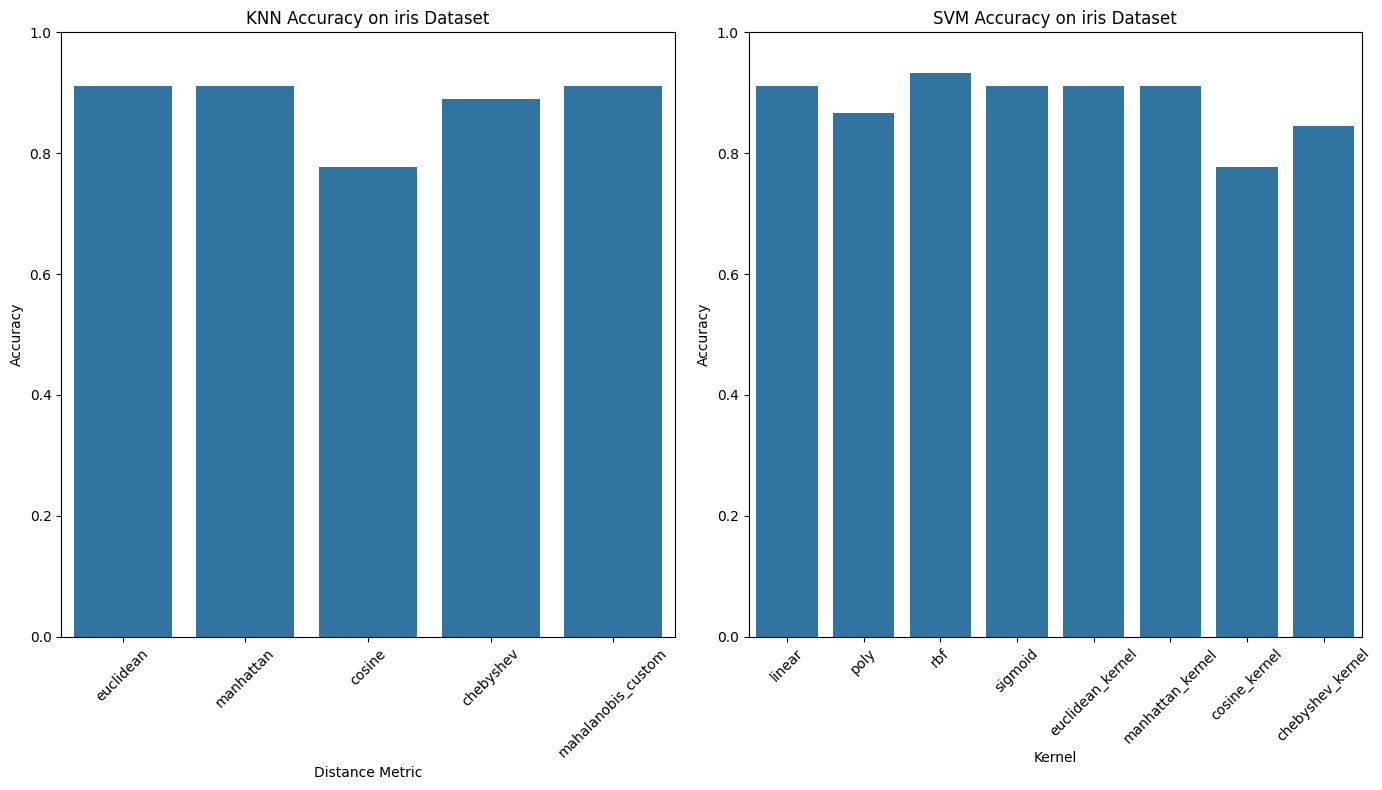

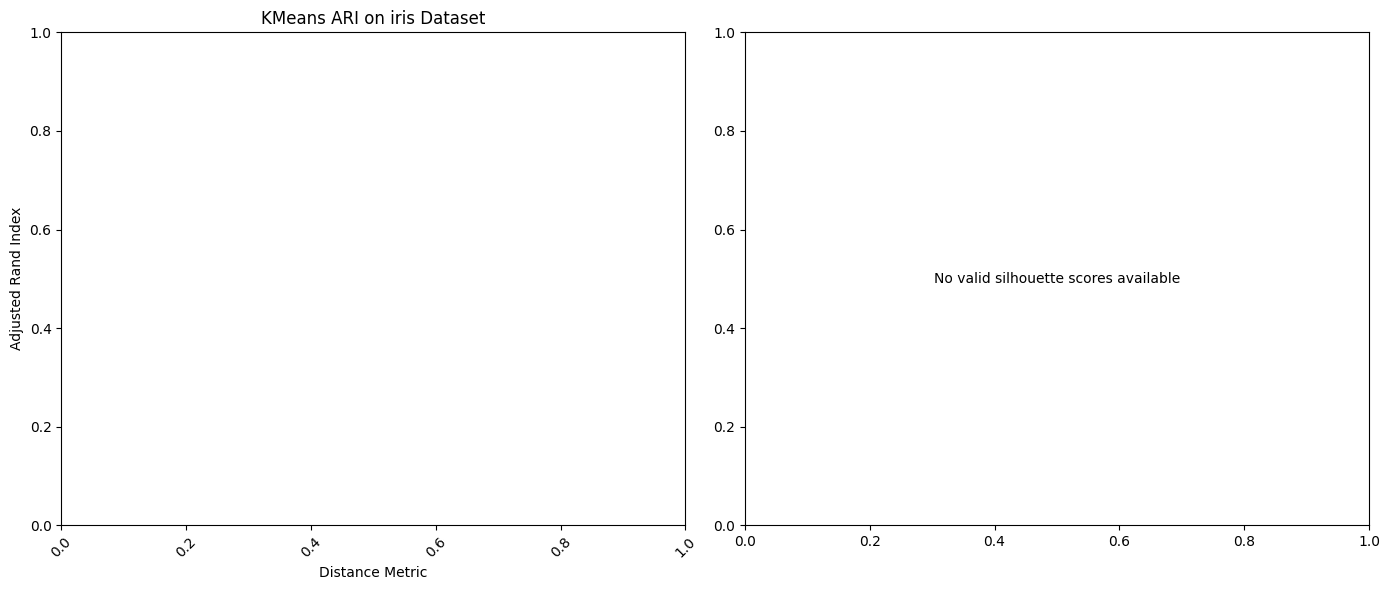

({'dataset': 'iris',
  'n_samples': 150,
  'n_features': 4,
  'n_classes': 3,
  'feature_names': ['sepal length (cm)',
   'sepal width (cm)',
   'petal length (cm)',
   'petal width (cm)'],
  'target_names': array(['setosa', 'versicolor', 'virginica'], dtype='<U10'),
  'knn': {'euclidean': {'accuracy': 0.9111111111111111,
    'time': 0.0029981136322021484,
    'model': KNeighborsClassifier(metric='euclidean')},
   'manhattan': {'accuracy': 0.9111111111111111,
    'time': 0.0028641223907470703,
    'model': KNeighborsClassifier(metric='manhattan')},
   'cosine': {'accuracy': 0.7777777777777778,
    'time': 0.0024259090423583984,
    'model': KNeighborsClassifier(metric='cosine')},
   'chebyshev': {'accuracy': 0.8888888888888888,
    'time': 0.002695322036743164,
    'model': KNeighborsClassifier(metric='chebyshev')},
   'mahalanobis_custom': {'accuracy': 0.9111111111111111,
    'time': 0.01499485969543457,
    'model': KNeighborsClassifier(metric=<function mahalanobis_example.<locals>.m

In [11]:
mahalanobis_example()

### Experiment 4

In [12]:
compare_datasets()


Evaluating iris dataset
Evaluating KNN on iris...
  euclidean: 0.9111
  manhattan: 0.9111
  cosine: 0.7778
  chebyshev: 0.8889
Evaluating KMeans on iris...
  Error with KMeans using euclidean: Invalid format specifier '.4f if results['kmeans'][metric_name]['silhouette'] is not None else 'N/A'' for object of type 'float'
  Error with KMeans using manhattan: AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'
  Error with KMeans using cosine: AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'
Evaluating SVM on iris...
  linear: 0.9111
  poly: 0.8667
  rbf: 0.9333
  sigmoid: 0.9111
  euclidean_kernel: 0.9111
  manhattan_kernel: 0.9111
  cosine_kernel: 0.7778
  chebyshev_kernel: 0.8444

Evaluating wine dataset
Evaluating KNN on wine...
  euclidean: 0.9444
  manhattan: 0.9815
  cosine: 0.9630
  chebyshev: 0.8889
Evaluating KMeans on wine...
  Error with KMeans using euclidean: Invalid format specifier '.4f if results['kmeans'][metr

NameError: name 'compare_knn_across_datasets' is not defined